In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = SVHN(path, transform=transform, download=True,split = 'train')
test_dataset  = SVHN(path, transform=transform, download=True, split = 'test')

100%|██████████| 182040794/182040794 [00:09<00:00, 20080400.84it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 23790947.53it/s]


In [ ]:
# load data and setup device
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
total = 0
for train_x in train_loader:
     total += (train_x[0].size())[0]
print(total)

73257


In [ ]:
# examples of input images
dataiter = iter(train_loader)
# returns tuple of images and labels in current batch
current_batch = next(dataiter)
print(current_batch[0].shape)#(n_samples, n_channels, h, w)
print(current_batch[1].size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


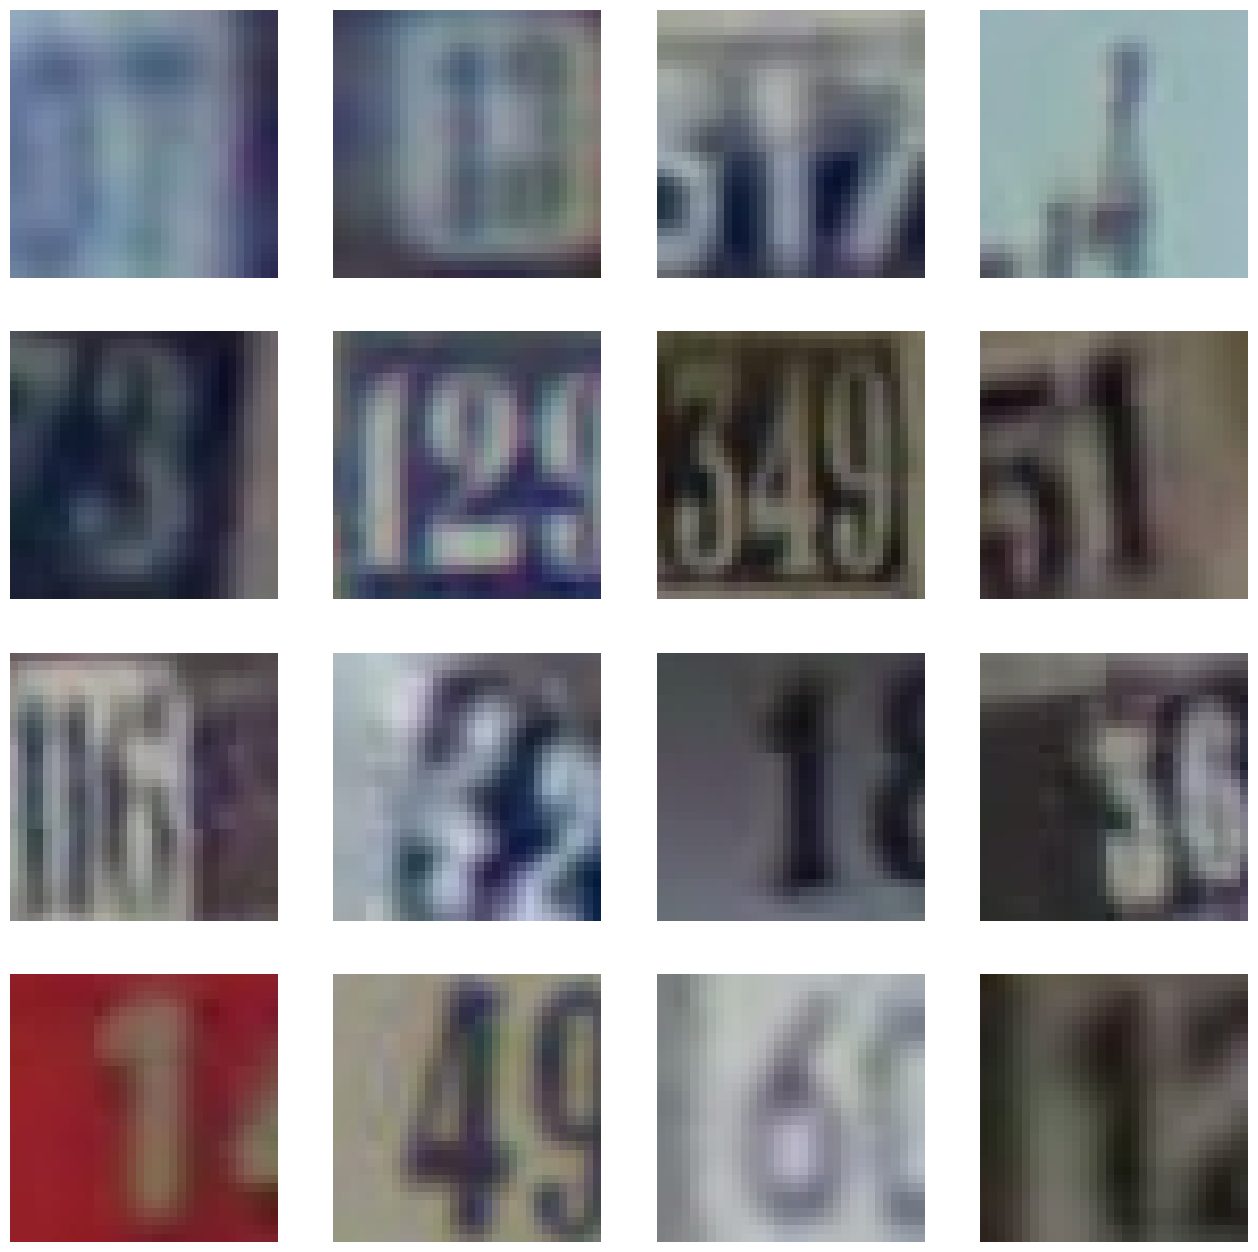

In [ ]:
images = current_batch[0]
fig,axs = plt.subplots(nrows = 4, ncols = 4,figsize = (16,16))
ax = axs.ravel()
for i in range(0,16):
        image = images[i,:,:,:]
        n_channels, height, width = image.shape
        image = image.reshape(n_channels,height, width)
        image = image.permute(1,2,0)
        ax[i].imshow(image, vmin = 0, vmax = 1, cmap = 'viridis')
        ax[i].axis('off')

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=32, n_channels = [3,32,64], latent_dim=1024, n_distribution = 200, device=device):# jel dovoljno ovde device
        super(VAE, self).__init__()

        # hyperparams
        self.n_channels = n_channels;
        self.latent_dim = latent_dim
        self.n_distribution = n_distribution
        self.input_dim = input_dim
        # encoder
        self.encoder = self.encoder_model()

        # latent mean and variance
        self.latent_mean = self.mean_layer()
        self.latent_logvar = self.log_var_layer()

        # decoder
        self.decoder_dense, self.decoder_conv = self.decoder_model()

    def encoder_model(self):
        flatten_dim = self.input_dim//4
        model = nn.Sequential(
        torch.nn.Conv2d(in_channels = self.n_channels[0], out_channels =  self.n_channels[1], kernel_size = (3,3),  stride = 2,padding = 1,device = device),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels =  self.n_channels[1], out_channels =  self.n_channels[2], kernel_size = (3,3),  stride = 2,padding = 1,device = device),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features = flatten_dim*flatten_dim*self.n_channels[2],out_features = self.latent_dim, device = device),
        torch.nn.ReLU()
        )
        return model
    def mean_layer(self):
        return torch.nn.Linear(in_features = self.latent_dim, out_features = self.n_distribution, device = device)

    def log_var_layer(self):
        return torch.nn.Linear(in_features = self.latent_dim, out_features = self.n_distribution,device = device)

    def decoder_model(self):
        flatten_dim = self.input_dim//4;
        model_dense = nn.Sequential(
        torch.nn.Linear(in_features = self.n_distribution,out_features = flatten_dim*flatten_dim*self.n_channels[2], device = device),
        torch.nn.ReLU())

        model_conv = nn.Sequential(
        torch.nn.ConvTranspose2d( in_channels =self.n_channels[2], out_channels =self.n_channels[2], kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1, device = device),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(in_channels = self.n_channels[2], out_channels = self.n_channels[1], kernel_size = (3,3),  stride = 2, padding = 1,output_padding = 1,device = device),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(in_channels = self.n_channels[1], out_channels = self.n_channels[0], kernel_size = (3,3),padding = 1,device = device),
        torch.nn.Sigmoid()
        )
        return (model_dense, model_conv)

    def encode(self, x):
        x = self.encoder(x)
        mean =  self.latent_mean(x)
        log_var = self.latent_logvar(x)
        return mean, log_var

    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(log_var).to(device)
        z = mean + ((0.5*log_var).exp())*epsilon
        return z

    def decode(self, x):
        x = self.decoder_dense(x);
        flatten_dim = self.input_dim//4;
        x = x.view((-1,self.n_channels[2],flatten_dim, flatten_dim))
        x = self.decoder_conv(x)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    def reconstruction_loss(self,x,x_hat):
        return torch.sum(torch.sum(nn.functional.binary_cross_entropy(x_hat, x,reduction = 'none'), dim = (1,2,3)))#mean
        #bce_loss = nn.BCELoss()
        #return bce_loss(x_hat, x)

    def KL_loss(self,mean, log_var):
        return torch.sum(- 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp(), dim = 1), dim = 0)#mean
    def loss_function(self,x, x_hat, mean, log_var):
        beta = 1;
        reconstruction = self.reconstruction_loss(x,x_hat)
        KLD = self.KL_loss(mean, log_var)
        return reconstruction + beta*KLD

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchsummary import summary
summary(model.encoder_model(),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
           Flatten-5                 [-1, 4096]               0
            Linear-6                 [-1, 1024]       4,195,328
              ReLU-7                 [-1, 1024]               0
Total params: 4,214,720
Trainable params: 4,214,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 16.08
Estimated Total Size (MB): 16.32
----------------------------------------------------------------


In [ ]:
summary(model.decoder_model()[0],(1,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]         823,296
              ReLU-2              [-1, 1, 4096]               0
Total params: 823,296
Trainable params: 823,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 3.14
Estimated Total Size (MB): 3.20
----------------------------------------------------------------


In [ ]:
summary(model.decoder_model()[1],(64,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 64, 16, 16]          36,928
              ReLU-2           [-1, 64, 16, 16]               0
   ConvTranspose2d-3           [-1, 32, 32, 32]          18,464
              ReLU-4           [-1, 32, 32, 32]               0
   ConvTranspose2d-5            [-1, 3, 32, 32]             867
           Sigmoid-6            [-1, 3, 32, 32]               0
Total params: 56,259
Trainable params: 56,259
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.80
Params size (MB): 0.21
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


	Epoch 1 	Average total loss:  1976.6490062383116 	Average reconstruction Loss:  1964.4649043777385 	Average KL Loss:  12.18409799476633
	Epoch 2 	Average total loss:  1940.3988910616051 	Average reconstruction Loss:  1925.8877760828316 	Average KL Loss:  14.511114940447777
	Epoch 3 	Average total loss:  1928.4742578994158 	Average reconstruction Loss:  1913.0339849135578 	Average KL Loss:  15.440277046703407
	Epoch 4 	Average total loss:  1923.1920378555974 	Average reconstruction Loss:  1907.7173262879314 	Average KL Loss:  15.474713645578985
	Epoch 5 	Average total loss:  1919.9378986393792 	Average reconstruction Loss:  1903.7895575465484 	Average KL Loss:  16.14834012635951
	Epoch 6 	Average total loss:  1918.0599796563808 	Average reconstruction Loss:  1901.6500114750127 	Average KL Loss:  16.409968997036707
	Epoch 7 	Average total loss:  1916.3275371722157 	Average reconstruction Loss:  1899.2735879762345 	Average KL Loss:  17.05395002997927
	Epoch 8 	Average total loss:  1915.4

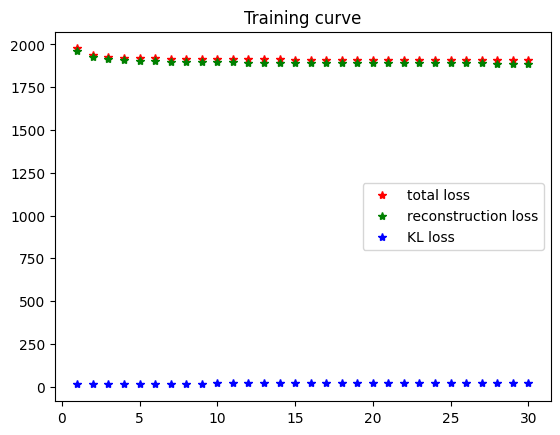

1908.5390183489292

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_KL_loss = 0;
        total_reconstruction_loss = 0;
        total_samples = 0;
        for batch_idx, (x, _) in enumerate(train_loader):
            #x_dim = (batch_size,1,28,28)
            #print(x.size())
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)

            reconstruction_loss = model.reconstruction_loss(x,x_hat)
            KL_loss = model.KL_loss(mean, log_var)
            loss = KL_loss+reconstruction_loss

            total_reconstruction_loss += reconstruction_loss.item()
            total_KL_loss += KL_loss.item()
            total_loss += loss.item()
            total_samples+=(x.size()[0])
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage total loss: ", total_loss/(total_samples),"\tAverage reconstruction Loss: ", total_reconstruction_loss/(total_samples),"\tAverage KL Loss: ", total_KL_loss/(total_samples))
        plt.plot(epoch+1,total_loss/(total_samples),'r*')
        plt.plot(epoch+1,total_reconstruction_loss/(total_samples),'g*')
        plt.plot(epoch+1,total_KL_loss/(total_samples),'b*')
    plt.legend(['total loss', 'reconstruction loss','KL loss'])
    plt.title('Training curve')
    plt.show()
    return total_loss/(total_samples)

train(model, optimizer, epochs=30, device=device)

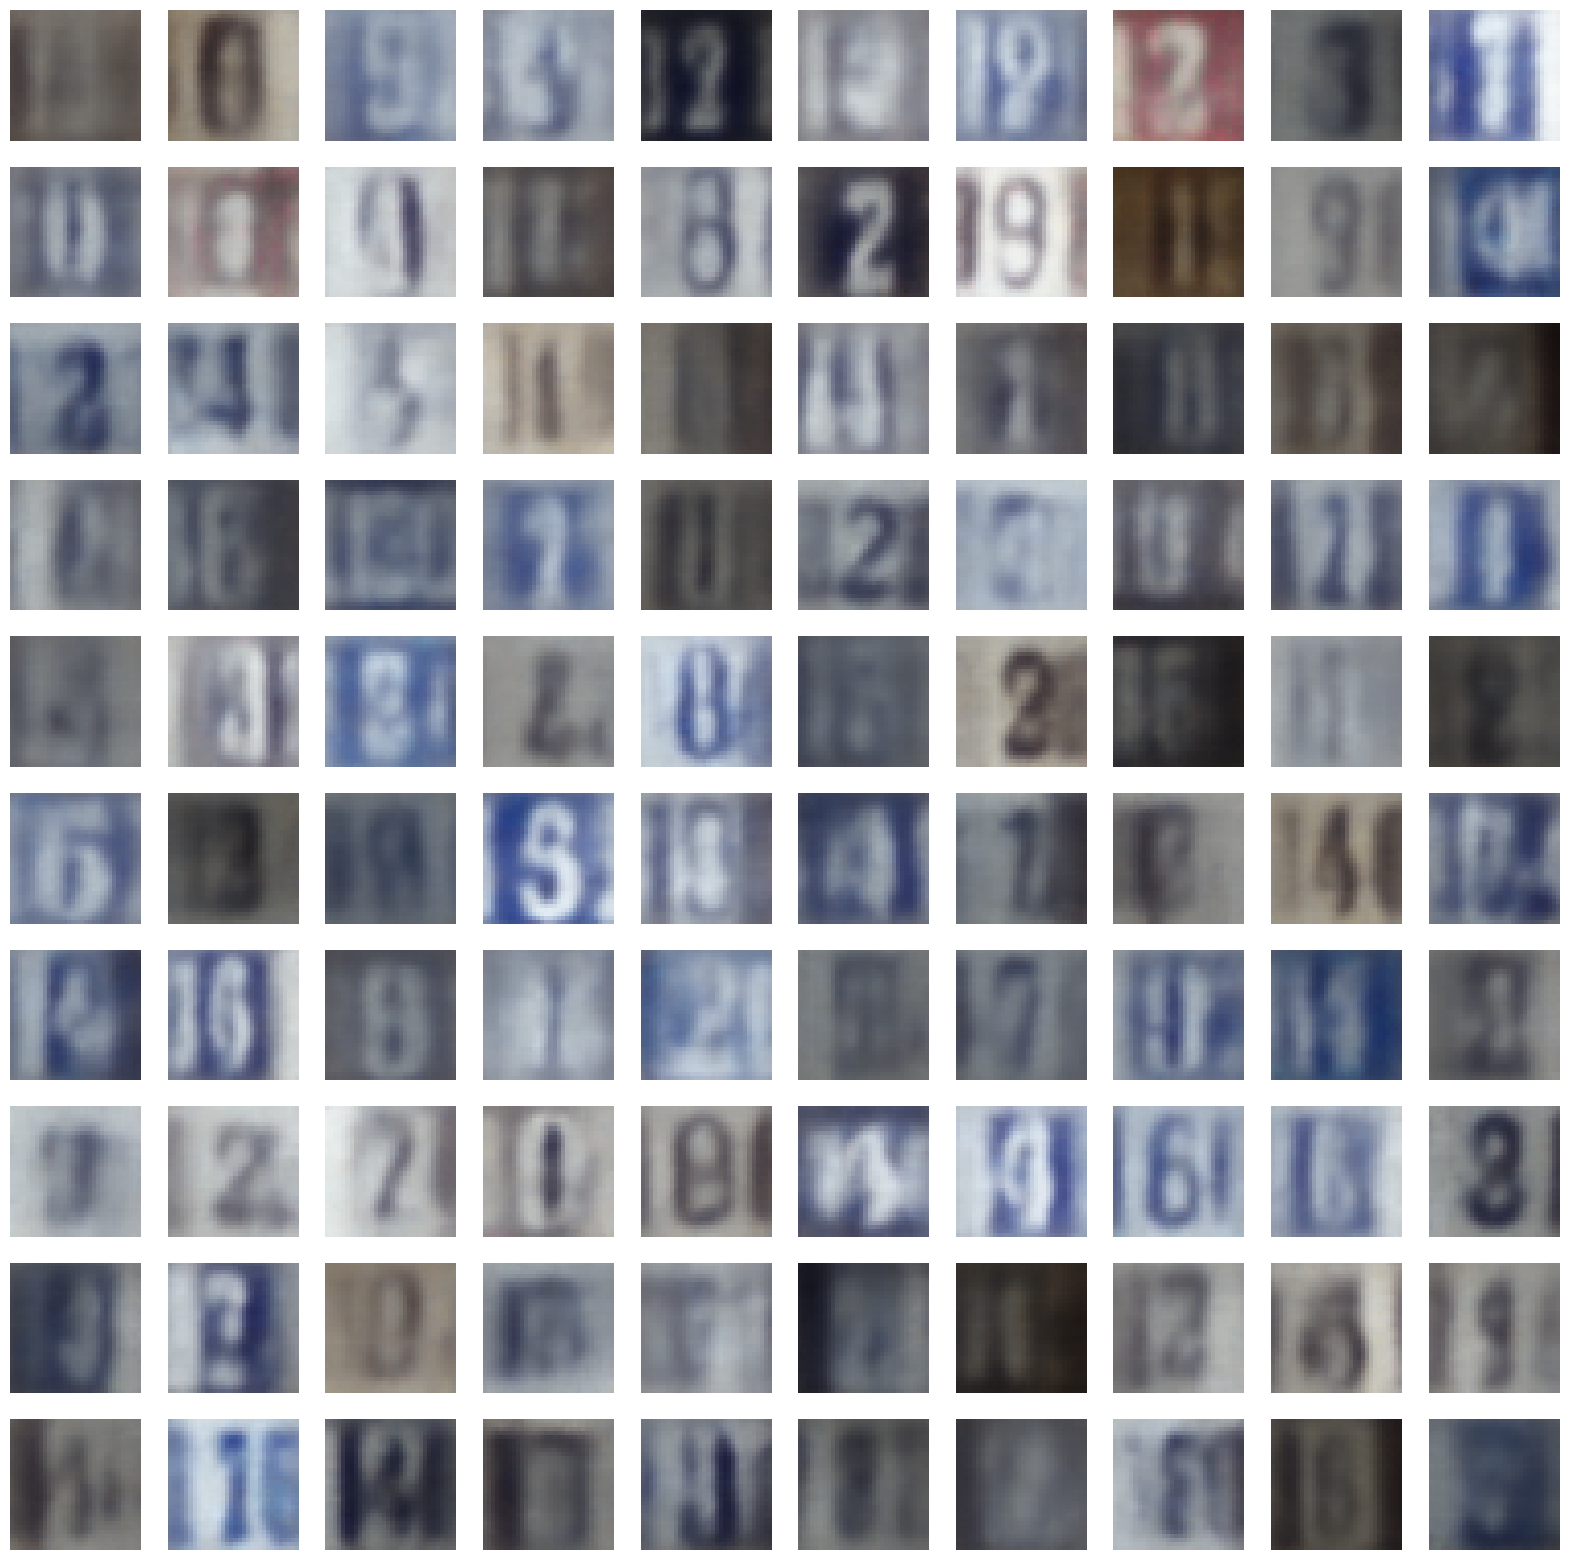

In [ ]:
n = 10
fig,axs = plt.subplots(nrows = n, ncols = n, figsize = (20,20))
for i in range(0,n):
  for j in range(0,n):
      z = torch.randn(1,200)
      x_decoded = model.decode(z)[0];
      image = x_decoded.permute(1,2,0)
      image = image.detach().numpy()
      axs[i,j].imshow(image, vmin = 0, vmax = 1, cmap = 'viridis')
      axs[i,j].axis('off')

In [ ]:
def test(model):
    total_loss = 0
    total_KL_loss = 0;
    total_reconstruction_loss = 0;
    total_samples = 0;
    for batch_idx, (x, _) in enumerate(train_loader):
            #x_dim = (batch_size,1,28,28)
            #print(x.size())
            x_hat, mean, log_var = model(x)

            reconstruction_loss = model.reconstruction_loss(x,x_hat)
            KL_loss = model.KL_loss(mean, log_var)
            loss = KL_loss+reconstruction_loss

            total_reconstruction_loss += reconstruction_loss.item()
            total_KL_loss += KL_loss.item()
            total_loss += loss.item()
            total_samples+=(x.size()[0])

    print("\tTest evaluation", "\tAverage total loss: ", total_loss/(total_samples),"\tAverage reconstruction Loss: ", total_reconstruction_loss/(total_samples),"\tAverage KL Loss: ", total_KL_loss/(total_samples))
test(model)

	Test evaluation 	Average total loss:  1908.7655641056485 	Average reconstruction Loss:  1888.0879527724312 	Average KL Loss:  20.67761405183416
